In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer
import hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict,ShuffleSplit
from imblearn.pipeline import Pipeline
import os
import numpy as np
import matplotlib.pyplot as plt
NPSEED = 1337
np.random.seed(NPSEED)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

,sex_1,sex_2,admitAge,admitCategoryCode_1,admitCategoryCode_2,entryCode_1,entryCode_2,entryCode_3,entryCode_4,admitByAmbulanceCode_1,...,raDrugAlcoholAbuse,raObesity,raStroke,raMentalHealth,raHepatic,raAsthma,raRheumatoid,raHIV,raPneumonia,riskTotal
1,1,0,90.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1,0,81.0,1,0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,1,0,72.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
7,1,0,88.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9,1,0,89.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Data shape (11126, 103)


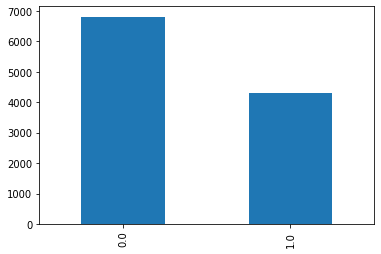

In [2]:
data = pickle.load(open('data/encoded_data.p','rb'))
display(data.head())
print(f"Data shape {data.shape}")
data['episodeDispositionCode'].value_counts().plot(kind='bar')
plt.show()
class_names =  ['Not continuing', 'Continuing Care']
features = list(data.keys())
features.remove('episodeDispositionCode')

In [3]:
data['episodeDispositionCode'].value_counts()

0.0    6807
1.0    4319
Name: episodeDispositionCode, dtype: int64

In [4]:
print('Features used:')
for feature in features:
    print(feature, end = ', ')

Features used:
sex_1, sex_2, admitAge, admitCategoryCode_1, admitCategoryCode_2, entryCode_1, entryCode_2, entryCode_3, entryCode_4, admitByAmbulanceCode_1, admitByAmbulanceCode_2, admitByAmbulanceCode_3, admitByAmbulanceCode_4, institutionZoneId_1, institutionZoneId_2, institutionZoneId_3, institutionZoneId_4, institutionZoneId_5, institutionZone_1, institutionZone_2, institutionZone_3, institutionZone_4, institutionZone_5, institutionTypeId_1, institutionTypeIdFrom_1, institutionTypeIdFrom_2, institutionTypeIdFrom_3, institutionTypeIdFrom_4, institutionTypeIdFrom_5, institutionTypeIdFrom_6, institutionTypeIdFrom_7, institutionTypeIdFrom_8, mainPatientService, mostRespDxCode_1, mostRespDxCode_2, mostRespDxCode_3, mostRespDxCode_4, mostRespDxCode_5, mostRespDxCode_6, mostRespDxCode_7, mostRespDxCode_8, mostRespDxCode_9, mostRespDxCode_10, mostRespDxCode_11, mostRespDxCode_12, mostRespDxCode_13, mostRespDxCode_14, mostRespDxCode_15, mostRespDxCode_16, mostRespDxCode_17, mostRespDxCode_1

In [166]:
# Drop 3/4 of positive samples to create imbalanced data set

data_true = data.loc[data['episodeDispositionCode'] ==1].sample(frac=1).reset_index(drop=True)
data_false = data.loc[data['episodeDispositionCode'] ==0]
data_imbalance = pd.concat([data_true[:240], data_false], axis=0).sample(frac=1).reset_index(drop=True)


# X = data.drop('episodeDispositionCode', axis=1)
# y = data['episodeDispositionCode']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify = y_train)
# feat_names = list(X_train.keys())


X_imbalance = data_imbalance.drop('episodeDispositionCode', axis=1)
y_imbalance = data_imbalance['episodeDispositionCode']
X_train, X_test, y_train, y_test = train_test_split(X_imbalance, y_imbalance, test_size=0.20, random_state=42, stratify = y_imbalance)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify = y_train)
feat_names = list(X_train.keys())


In [184]:
print('We made up an imbalanced data set where only\t', np.round(sum(y_train==1)/len(y_train),3),'sample is positive')


We made up an imbalanced data set where only	 0.034 sample is positive


In [322]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent",random_state=33).fit(X_train,y_train) 
y_val_pred_dummy = dummy_clf.predict(X_valid)
y_pred_dummy = dummy_clf.predict(X_test) 


## Use is_unbalance = True as the objective parameter
#clf = lgbm.LGBMClassifier(is_unbalance=True,random_state=33,learning_rate=0.1, early_stopping_rounds = 10, n_estimators=10000)


## Use iscale_pos_weight as the objective parameter
clf = lgbm.LGBMClassifier(scale_pos_weight=len(y_train)/sum(y_train==1)*3 ,random_state=33,learning_rate=0.1, early_stopping_rounds = 10, n_estimators=10000)

clf.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=False)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]
y_val_pred = clf.predict(X_valid)
y_val_probs = clf.predict_proba(X_valid)[:,1]

In [213]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names =  ['Not continuing', 'Continuing Care']    
    df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},  fmt='d')
    plt.show()
    metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    display(df_cm)

We see that for 

## Explaining the decision
We use a method called SHAP (SHapley Additive exPlanations). 
This plot is made of all the points in the validation data. It demonstrates the following information:
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis. 

The explanations of why the model performed the way it did on the test set is as follows.

In [171]:
# Define costomized cost function

def Cost(y_pred, y_true, C_p, C_n):
    residual= (y_true - y_pred).astype("float")
    #print('Residual:\t',residual)
    loss = np.where(residual <=0, (residual**2)*C_p, residual**2*C_n)
    #print('Loss:\t',loss[:20])
    return np.mean(loss)

In [172]:
# Define custom objective function -- Weighted Logistic Regression
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.misc import derivative

def weighted_loss_lgb_sk(y_true, y_pred, c_p, c_n):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray array with the predictions
    dtrain: lightgbm.Dataset
    c_p, c_n: float
    """
    def fl(x,t):
        #p = 1/(1+np.exp(-x))
        p = 1/(1+np.exp(-(x-.5)*2))
        #print(x)
        #print(p)
        return - ( c_n*t*np.log(p)+c_p*(1-t)*np.log(1-p) )

    
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess



def weighted_loss_lgb_eval_error_sk(y_true, y_pred, c_p, c_n):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
     c_p, c_n: float
    """
 
    #p = 1/(1+np.exp(-y_pred))
    p = 1/(1+np.exp(-(y_pred-0.5)*2))
    loss = - ( c_n* y_true*np.log(p)+c_p*(1-y_true)*np.log(1-p) )
    return 'weighted_loss', np.mean(loss), False


In [173]:
# Focal loss function

def focal_loss_lgb_sk(y_true, y_pred, alpha, gamma):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    def fl(x,t):
        p = 1/(1+np.exp(-x))        
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
        #return  -a*t*((1-p)**g)*np.log(p)-(1-a)*(1-t)*(p**g)*np.log(1-p) 
    partial_fl = lambda x: fl(x, y_true)

    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess



def focal_loss_lgb_eval_error_sk(y_true, y_pred, alpha, gamma):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    p = 1/(1+np.exp(-y_pred))
    #loss = -a*y_true*((1-p)**g)*np.log(p)-(1-a)*(1-y_true)*(p**g)*np.log(1-p) 
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False

In [324]:
# Repredict y_pred_direct

# make new model on new value
# Define weights here

c_p=1
c_n=100
#c_n=len(y_train)/sum(y_train==1)


weighted_loss = lambda x,y: weighted_loss_lgb_sk(x, y, c_p, c_n)
eval_error_weighted = lambda x,y: weighted_loss_lgb_eval_error_sk(x, y, c_p, c_n)


clf_direct = lgbm.LGBMClassifier(random_state=33,
                                early_stopping_rounds = 10,
                                learning_rate=0.1,
                                n_estimators=10000,
                                objective= weighted_loss)

#clf_direct = lgbm.LGBMClassifier()
#clf_direct.set_params(**{'objective': weighted_loss})

clf_direct.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=eval_error_weighted,
    verbose=False,
)



y_pred_direct = clf_direct.predict(X_test)
y_prob_direct = clf_direct.predict_proba(X_test)[:,1]
y_val_pred_direct = clf_direct.predict(X_valid)
y_val_probs_direct = clf_direct.predict_proba(X_valid)[:,1]




In [325]:
# Repredict y_pred_fl

# make new model on new value
# Define alpha and gamma here

## The following parameters will produce higher F1 score
alpha=.95
gamma=2


## The following parameters will produce higher recall on the positive cases
#alpha=.99
#gamma=1


focal_loss = lambda x,y: focal_loss_lgb_sk(x, y, alpha, gamma)
eval_error = lambda x,y: focal_loss_lgb_eval_error_sk(x, y, alpha,gamma)

clf_fl = lgbm.LGBMClassifier(random_state=33,
                                early_stopping_rounds = 10,
                                learning_rate=0.1,
                                n_estimators=10000,
                                objective= focal_loss)


clf_fl.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=eval_error,
    verbose=False,
)


y_pred_fl = clf_fl.predict(X_test)
y_prob_fl = clf_fl.predict_proba(X_test)[:,1]
y_val_pred_fl = clf_fl.predict(X_valid)
y_val_probs_fl = clf_fl.predict_proba(X_valid)[:,1]




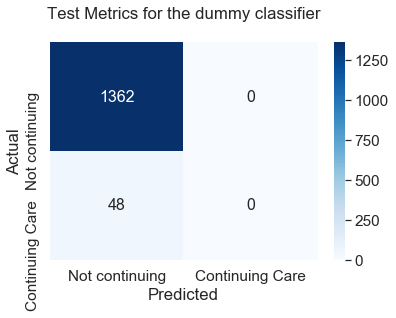

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.965957,0.0
Recall,1.000000,0.0
F,0.982684,0.0
Support,1362.000000,48.0


The cost of miscalssification under the dummy model is 	 3.4


In [287]:
plt.title('Test Metrics for the dummy classifier\n')
get_metrics(y_test, y_pred_dummy)
print('The cost of miscalssification under the dummy model is \t',np.round(Cost(y_pred_dummy, y_test, c_p, c_n),2))




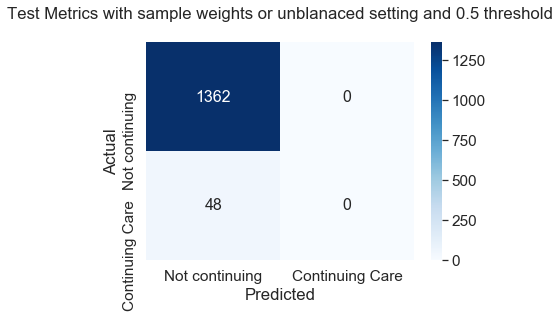

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.965957,0.0
Recall,1.000000,0.0
F,0.982684,0.0
Support,1362.000000,48.0


The cost of miscalssification under the default model is 	 1.0


In [323]:
plt.title('Test Metrics with sample weights or unblanaced setting and 0.5 threshold\n')
get_metrics(y_test, y_pred)

print('The cost of miscalssification under the default model is \t',np.round(Cost(y_pred, y_test, c_p, c_n),2))

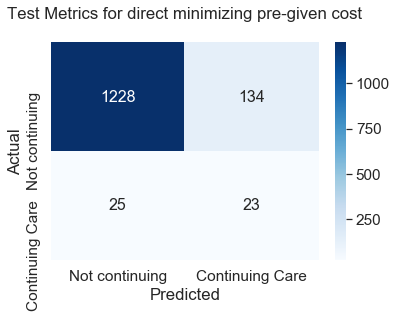

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.980048,0.146497
Recall,0.901615,0.479167
F,0.939197,0.224390
Support,1362.000000,48.000000


The cost of miscalssification under the direct optimized model is 	 0.61


In [321]:
plt.title('Test Metrics for direct minimizing pre-given cost\n')
get_metrics(y_test, y_pred_direct)
 
print('The cost of miscalssification under the direct optimized model is \t',np.round(Cost(y_pred_direct, y_test, c_p, c_n),2))






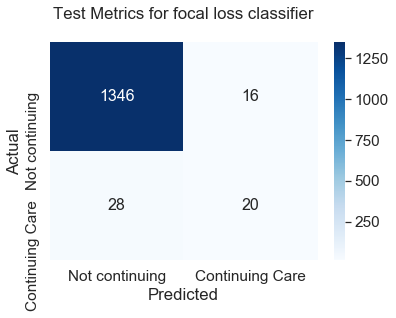

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.979622,0.555556
Recall,0.988253,0.416667
F,0.983918,0.476190
Support,1362.000000,48.000000


0.4761904761904762 

The cost of miscalssification under the focal loss model is 	 2.0


In [299]:
plt.title('Test Metrics for focal loss classifier\n')
get_metrics(y_test, y_pred_fl)
print(f1_score(y_test, y_pred_fl),'\n')
print('The cost of miscalssification under the focal loss model is \t',np.round(Cost(y_pred_fl, y_test, c_p, c_n),2))

In [311]:
print(y_pred_fl[:25])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


In [183]:
print(y_prob_fl[:25])

[-0.71899542  0.73364321 -0.72317838  0.53085159 -0.81789396 -1.13393883
 -0.56243303 -1.0383824  -0.85333649 -1.13393883 -1.13393883 -1.13393883
  0.73364321  0.73364321  0.8255532   1.06704984 -1.2575358  -1.18324094
 -1.17319605 -0.05743346 -1.13393883  0.73364321  0.73364321 -0.92171964
 -0.95188432]


                <----------Classifer output (probability)--------->
                 
|-------------------------------------*---------------------------------------------|
0   'Not continuing care'           theta        'Continuing care'                  1

In [309]:
# mimic what's been done but only use one decision thredhold
y_pred_cs = np.ones(y_valid.shape)
cmin = 999999
vmax = -999999
pmax = 0

for theta in np.linspace(0,1,10):

    y_pred_cs = np.ones(y_valid.shape)
    y_pred_cs[y_val_probs <= theta] = 0
    y_pred_cs[y_val_probs > theta] = 1
   
    # Confusion metrix for each thredhold
    cm = confusion_matrix(y_valid, y_pred_cs)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1]
 

    class_names =  [ 'Continuing Care'] 
    metrics = np.array( precision_recall_fscore_support(y_valid, y_pred_cs,beta=1,average ='binary') )
    print('theta\t',theta,'matric\t',metrics,'\n')
    
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
        
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    cost_to_be_mimimized = Cost(y_pred_cs, y_valid, c_p, c_n)
    var_to_be_maximized =  metrics[2]
    
    #print(f"Not continuing care <{np.around(theta,2)}, and continuing care >{np.around(theta,2)}: F score = {np.around(var_to_be_maximized,2)}")
    #print(f"Not continuing care <{np.around(theta,2)}, and continuing care >{np.around(theta,2)}: cost = {np.around(Cost(y_pred_3, y_valid, c_p, c_n),2)}")
    
    
    # Track the best decision thredhold
#   if cmin > (cost_to_be_mimimized):
#         cmin = (cost_to_be_mimimized)
#         pmax = theta

    if  vmax < var_to_be_maximized:
        vmax = (var_to_be_maximized)
        pmax = theta

print(f'\n Best cutoffs cost = {np.around(vmax,3)} for Not continuing care <{np.around(pmax,2)},  and continuing care >{np.around(pmax,2)}')




theta	 0.0 matric	 [0.03368794326241135 1.0 0.06518010291595197 None] 

theta	 0.1111111111111111 matric	 [0.08157894736842106 0.8157894736842105 0.14832535885167464 None] 

theta	 0.2222222222222222 matric	 [0.2714285714285714 0.5 0.35185185185185186 None] 

theta	 0.3333333333333333 matric	 [0.5625 0.47368421052631576 0.5142857142857142 None] 

theta	 0.4444444444444444 matric	 [0.0 0.0 0.0 None] 

theta	 0.5555555555555556 matric	 [0.0 0.0 0.0 None] 

theta	 0.6666666666666666 matric	 [0.0 0.0 0.0 None] 

theta	 0.7777777777777777 matric	 [0.0 0.0 0.0 None] 

theta	 0.8888888888888888 matric	 [0.0 0.0 0.0 None] 

theta	 1.0 matric	 [0.0 0.0 0.0 None] 


 Best cutoffs cost = 0.514 for Not continuing care <0.33,  and continuing care >0.33


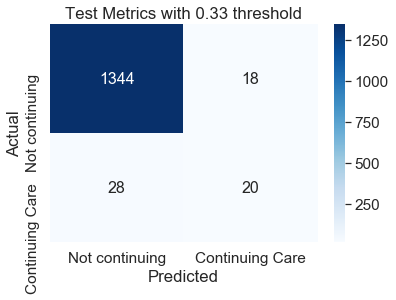

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.979592,0.526316
Recall,0.986784,0.416667
F,0.983175,0.465116
Support,1362.000000,48.000000


0.46511627906976744 

The cost of miscalssification under the focal loss model is 	 2.0


In [312]:
plt.title(f'Test Metrics with {np.around(pmax,2)} threshold')
get_metrics(y_test, y_prob>pmax)
print(f1_score(y_test, y_prob>pmax),'\n')
print('The cost of miscalssification under the focal loss model is \t',np.round(Cost(y_prob>pmax, y_test, c_p, c_n),2))

We see that with further tuning performance of the classifier can be improved. 